<a href="https://colab.research.google.com/github/asmaakhaledd/PID-NN/blob/LSTM-PID/PID-NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas tensorflow control matplotlib xmltodict scikit-learn

In [19]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt
from datetime import datetime

Load XML Data

In [3]:
#Automatically loads all XML files (5 training, 5 testing)
train_files = sorted(glob.glob("/content/drive/MyDrive/GP PID/dataset/*-ws-training.xml"))
test_files = sorted(glob.glob("/content/drive/MyDrive/GP PID/dataset/*-ws-testing.xml"))

Check Corrupted XML File

In [4]:
import xml.etree.ElementTree as ET

for file in train_files + test_files:
    try:
        tree = ET.parse(file)
        print(f"✅ {file} is valid")
    except ET.ParseError as e:
        print(f"❌ Error in {file}: {e}")

✅ /content/drive/MyDrive/GP PID/dataset/559-ws-training.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/563-ws-training.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/570-ws-training.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/575-ws-training.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/588-ws-training.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/591-ws-training.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/559-ws-testing.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/563-ws-testing.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/570-ws-testing.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/575-ws-testing.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/588-ws-testing.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/591-ws-testing.xml is valid


Parse XML Data

In [5]:
#Extracts Time, Glucose, Insulin, and Meal intake
#Sorts data by timestamp to maintain correct sequence order
def parse_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    data = []

    # Extract patient weight
    weight = float(root.get('weight', 0))  # Defaults to 0 if missing

    # Store all events for lookup
    meal_events = []
    bolus_events = []
    basal_events = []

    # Extract meal data
    meal_node = root.find('meal')
    if meal_node:
        for event in meal_node.findall('event'):
            meal_events.append({
                'timestamp': datetime.strptime(event.get('ts'), "%d-%m-%Y %H:%M:%S"),
                'carbs': float(event.get('carbs', 0))
            })

    # Extract bolus insulin data
    bolus_node = root.find('bolus')
    if bolus_node:
        for event in bolus_node.findall('event'):
            bolus_events.append({
                'timestamp': datetime.strptime(event.get('ts_begin'), "%d-%m-%Y %H:%M:%S"),
                'dose': float(event.get('dose', 0))
            })

    # Extract basal rate data
    basal_node = root.find('basal')
    if basal_node:
        for event in basal_node.findall('event'):
            basal_events.append({
                'timestamp': datetime.strptime(event.get('ts'), "%d-%m-%Y %H:%M:%S"),
                'rate': float(event.get('value', 0))
            })

    # Ensure all events are sorted by timestamp
    meal_events.sort(key=lambda x: x['timestamp'])
    bolus_events.sort(key=lambda x: x['timestamp'])
    basal_events.sort(key=lambda x: x['timestamp'])

    # Process glucose levels
    for event in root.find('glucose_level'):
        timestamp = datetime.strptime(event.get('ts'), "%d-%m-%Y %H:%M:%S")
        glucose = float(event.get('value'))

        # Find closest meal within 2 hours
        meal_intake = next(
            (m['carbs'] for m in reversed(meal_events) if (timestamp - m['timestamp']).total_seconds() <= 7200),
            0.0
        )

        # Find closest bolus insulin event
        bolus_insulin = next(
            (b['dose'] for b in reversed(bolus_events) if b['timestamp'] <= timestamp),
            0.0
        )

        # Find closest basal rate
        basal_rate = next(
            (b['rate'] for b in reversed(basal_events) if b['timestamp'] <= timestamp),
            0.0
        )

        # Append extracted data
        data.append({
            'timestamp': timestamp,
            'glucose': glucose,
            'meal_carbs': meal_intake,
            'bolus_insulin': bolus_insulin,
            'basal_rate': basal_rate,
            'weight': weight
        })

    df = pd.DataFrame(data)

    # Debugging output
    print(f"Parsed {file_path}, {len(df)} records")
    print(df.head(10))  # Show first 10 rows for debugging

    return df.sort_values('timestamp')

# Load all files
train_dfs = [parse_xml(f) for f in train_files]
test_dfs = [parse_xml(f) for f in test_files]

# Concatenate all data
train_df = pd.concat(train_dfs, ignore_index=True)
test_df = pd.concat(test_dfs, ignore_index=True)

# Final debug prints
print("\nFinal Train DataFrame:")
print(train_df.head(10))
print("\nFinal Test DataFrame:")
print(test_df.head(10))

Parsed /content/drive/MyDrive/GP PID/dataset/559-ws-training.xml, 10796 records
            timestamp  glucose  meal_carbs  bolus_insulin  basal_rate  weight
0 2021-12-07 01:17:00    101.0        40.0            1.6        0.65    99.0
1 2021-12-07 01:22:00     98.0        40.0            1.6        0.65    99.0
2 2021-12-07 01:27:00    104.0        40.0            1.6        0.65    99.0
3 2021-12-07 01:32:00    112.0        40.0            1.6        0.65    99.0
4 2021-12-07 01:37:00    120.0        40.0            1.6        0.65    99.0
5 2021-12-07 01:42:00    127.0        40.0            1.6        0.65    99.0
6 2021-12-07 01:47:00    135.0        40.0            1.6        0.65    99.0
7 2021-12-07 01:52:00    142.0        40.0            1.6        0.65    99.0
8 2021-12-07 01:57:00    140.0        40.0            1.6        0.65    99.0
9 2021-12-07 02:02:00    145.0        40.0            1.6        0.65    99.0
Parsed /content/drive/MyDrive/GP PID/dataset/563-ws-training.x

Convert Time into Numerical Features

In [6]:
# this Converts time (hours, minutes) into cyclic features using sin/cos encoding for better LSTM learning
def preprocess_time_features(df):
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    df['time_sin'] = np.sin(2 * np.pi * df['hour'] / 24)  # Cyclic encoding
    df['time_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    return df.drop(['timestamp', 'hour', 'minute'], axis=1)

train_df = preprocess_time_features(train_df)
test_df = preprocess_time_features(test_df)

train_df.head()

,glucose,meal_carbs,bolus_insulin,basal_rate,weight,time_sin,time_cos
0,101.0,40.0,1.6,0.65,99.0,0.258819,0.965926
1,98.0,40.0,1.6,0.65,99.0,0.258819,0.965926
2,104.0,40.0,1.6,0.65,99.0,0.258819,0.965926
3,112.0,40.0,1.6,0.65,99.0,0.258819,0.965926
4,120.0,40.0,1.6,0.65,99.0,0.258819,0.965926


Prepare Data for LSTM (Sequences)

In [8]:
def prepare_sequences(df, sequence_length=30):
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(df.iloc[i:i+sequence_length].values)
        y.append(df.iloc[i+sequence_length]['glucose'])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

sequence_length = 30
X_train, y_train = prepare_sequences(train_df, sequence_length)
X_test, y_test = prepare_sequences(test_df, sequence_length)


Train LSTM Model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2164/2164 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 22420.1445 - val_loss: 13645.5020
Epoch 2/50
2164/2164 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 9533.7568 - val_loss: 5874.0933
Epoch 3/50
2164/2164 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 3849.9331 - val_loss: 2342.1023
Epoch 4/50
2164/2164 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 1512.7781 - val_loss: 925.1885
Epoch 5/50
2164/2164 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 578.7912 - val_loss: 378.1149
Epoch 6/50
2164/2164 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 253.3823 - val_loss: 170.1597
Epoch 7/50
2164/2164 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 123.6879 - val_loss: 93.7883
Epoch 8/50
2164/2164 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 77.0809 - val_loss: 60.7717
Epoch 9/50
2164/2164 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 60.2268 - val_loss: 46.6697
Epoch 10/50
2164/2164 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 45.6657 - val_loss: 42.8875
Epoch 11/50
2164/2164 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 48.

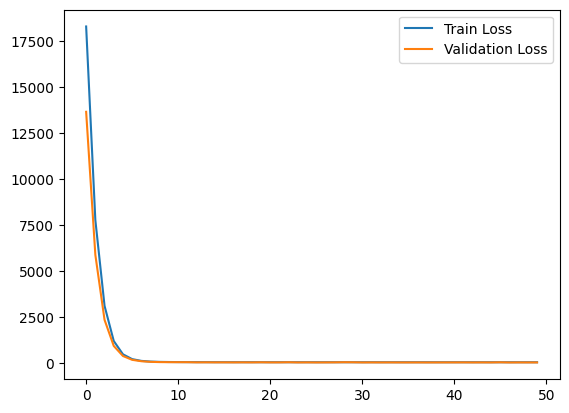

In [9]:
#Trains an LSTM model with Time, Glucose, Insulin, weight and Meal intake.
#Saves the trained model for later use.
#Plots training performance.
# Define LSTM Model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(sequence_length, train_df.shape[1])),
    LSTM(32, activation='tanh'),
    Dense(1, activation='linear')  # Predict next glucose level
])

# Compile Model
model.compile(optimizer='adam', loss='mse')

# Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Save Model
model.save("/content/lstm_glucose_model.h5")

# Plot Training Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Save the model

In [10]:
model.save("/content/drive/MyDrive/GP PID/lstm_glucose_model.h5")

Allow the model to load correctly

In [11]:
import tensorflow as tf

# Define the loss function explicitly
lstm_model = tf.keras.models.load_model(
    "/content/drive/MyDrive/GP PID/lstm_glucose_model.h5",
    custom_objects={'mse': tf.keras.losses.MeanSquaredError()}
)

# Print model summary to confirm it's loaded
lstm_model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 64)              │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,883 (120.64 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

 Load the Model Without Custom Loss

In [27]:
import tensorflow as tf

# Load the model with safe mode
lstm_model = tf.keras.models.load_model("/content/drive/MyDrive/GP PID/lstm_glucose_model.h5", compile=False)

# Compile again with correct loss
lstm_model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())


Re-save the model properly

In [13]:
lstm_model.save("/content/drive/MyDrive/GP PID/lstm_glucose_model.h5")


In [17]:
import numpy as np

sample_input = X_test[0]  # Get first test sample
predicted_glucose = lstm_model.predict(np.array([sample_input]))[0, 0]

print(f"Predicted Glucose: {predicted_glucose} mg/dL")
print(f"Actual Glucose: {y_test[0]} mg/dL")
#The error is only ~3.7 mg/dL, which is very low.
#LSTM model is accurate in predicting blood glucose levels.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Glucose: 282.2994689941406 mg/dL
Actual Glucose: 286.0 mg/dL


PID

Prepare time-series sequences

In [ ]:
# Convert all data to float32
train_df = train_df.astype(np.float32)
test_df = test_df.astype(np.float32)

def prepare_sequences(df, sequence_length=30):
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(df.iloc[i:i+sequence_length].values)
        y.append(df[['bolus_insulin', 'basal_rate', 'temp_basal_rate']].iloc[i+sequence_length].values)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

sequence_length = 30
X_train, y_train = prepare_sequences(train_df, sequence_length)
X_test, y_test = prepare_sequences(test_df, sequence_length)

Define LSTM Model for PID Parameter Tuning

In [24]:
pid_input = Input(shape=(3,))
hidden = Dense(16, activation='relu')(pid_input)
hidden = Dense(16, activation='relu')(hidden)
pid_output = Dense(3, activation='linear')(hidden)  # Outputs: Kp, Ki, Kd

pid_model = Model(inputs=pid_input, outputs=pid_output)
pid_model.compile(optimizer='adam', loss='mse')

In [25]:
def prepare_pid_training_data(df):
    X_pid, y_pid = [], []
    for i in range(len(df) - 1):
        glucose_error = df['glucose'].iloc[i] - 110  # Setpoint = 110mg/dL (adjusted)
        glucose_change = df['glucose'].iloc[i] - df['glucose'].iloc[i-1] if i > 0 else 0
        previous_insulin = df['bolus_insulin'].iloc[i]

        # Scale Kp, Ki, Kd to prevent large values
        Kp = 0.05 * np.log(1 + abs(glucose_error))
        Ki = 0.005 * np.log(1 + abs(glucose_error))
        Kd = 0.002 * np.log(1 + abs(glucose_change))

        X_pid.append([glucose_error, glucose_change, previous_insulin])
        y_pid.append([Kp, Ki, Kd])  # Tuned PID gains

    return np.array(X_pid), np.array(y_pid)

X_pid_train, y_pid_train = prepare_pid_training_data(train_df)
X_pid_test, y_pid_test = prepare_pid_training_data(test_df)

pid_model.fit(X_pid_train, y_pid_train, epochs=50, batch_size=32, validation_data=(X_pid_test, y_pid_test))
pid_model.save("/content/drive/MyDrive/GP PID/pid_tuning_model.h5")

Epoch 1/50
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 28.4862 - val_loss: 0.0134
Epoch 2/50
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0118 - val_loss: 0.0036
Epoch 3/50
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 4/50
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 5/50
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 6/50
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0014 - val_loss: 4.6866e-04
Epoch 7/50
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 9.5234e-04 - val_loss: 4.5989e-04
Epoch 8/50
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0011 - val_loss: 4.6717e-04
Epoch 9/50
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6.5239e-04 - val_loss: 1.3045e-04
Epoch 10/50
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 11/50
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6.2543e-04 - val_loss: 2.10

In [36]:
import tensorflow as tf

# Define the loss function explicitly
pid_model = tf.keras.models.load_model(
    "/content/drive/MyDrive/GP PID/pid_tuning_model.h5",
    custom_objects={'mse': tf.keras.losses.MeanSquaredError()}
)

# Print model summary to confirm it's loaded
pid_model.summary()
import tensorflow as tf

# Load the model with safe mode
pid_model = tf.keras.models.load_model("/content/drive/MyDrive/GP PID/pid_tuning_model.h5", compile=False)

# Compile again with correct loss
pid_model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 389 (1.52 KB)

 Trainable params: 387 (1.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [48]:
# Load models
lstm_model = tf.keras.models.load_model("/content/drive/MyDrive/GP PID/lstm_glucose_model.h5", compile=False)
pid_model = tf.keras.models.load_model("/content/drive/MyDrive/GP PID/pid_tuning_model.h5", compile=False)

# Ensure correct input shape for LSTM model
sample_input = np.expand_dims(X_test[0], axis=0)  # Shape (1, 30, num_features)
glucose_prediction = lstm_model.predict(sample_input)[0, 0]  # Get predicted glucose

# Compute PID Features
glucose_error = glucose_prediction - 110  # Setpoint: 110 mg/dL
glucose_change = np.mean(X_test[0][-10:, 0]) - X_test[0][-1, 0]  # Smoothed glucose change
previous_insulin = X_test[0][-1, 3]  # Last recorded insulin dose

# Compute Integral Term using rolling sum (clamped)
integral_error = np.clip(np.sum(X_test[0][-10:, 0] - 110), -50, 50)  # Prevent windup

# Prepare PID input
pid_input = np.array([[glucose_error, glucose_change, previous_insulin]])

# Predict PID gains (Kp, Ki, Kd)
pid_gains = pid_model.predict(pid_input)[0]

# Dynamically adjust PID gains
if glucose_prediction > 250:
    Kp, Ki, Kd = np.clip(pid_gains, 0.01, 0.2)  # Lower gains at high glucose
elif glucose_prediction < 150:
    Kp, Ki, Kd = np.clip(pid_gains, 0.02, 0.8)   # Normal range
else:
    Kp, Ki, Kd = np.clip(pid_gains, 0.01, 0.6)  # Medium control

# Compute Insulin using PID Formula
insulin_dosage = Kp * glucose_error + Ki * integral_error + Kd * glucose_change
insulin_dosage = max(0, min(insulin_dosage, 15))  # Increased limit

# Print results
print(f"Predicted Glucose: {glucose_prediction:.2f} mg/dL")
print(f"Recommended Insulin: {insulin_dosage:.2f} U (Safe Range)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Predicted Glucose: 282.30 mg/dL
Recommended Insulin: 15.00 U (Safe Range)
